In [1]:
import os
import pathlib

In [6]:
from keras.preprocessing import image
import numpy as np
from matplotlib import pyplot as plt

# Loading Dataset

In [43]:
path = pathlib.Path('Dataset/')
dirs = path.glob("*")
imageData = []
labels = []
labelsDict = {
    'Pikachu': 0,
    'Bulbasaur': 1,
    'Meowth': 2
}
pokemonDict = {
    0: 'Pikachu',
    1: 'Bulbasaur',
    2: 'Meowth'
}
for folder in dirs:
    label = str(folder).split('/')[-1]
    c = 0
    for imgPath in folder.glob('*.jpg'):
        img = image.load_img(imgPath, target_size=(40, 40))
        imageArray = image.img_to_array(img)
        imageData.append(imageArray)
        labels.append(labelsDict[label])
        c += 1
    print(label, c)


Pikachu 199
Bulbasaur 171
Meowth 70


# Visualization

In [56]:
len(imageData), len(labels)

(440, 440)

In [57]:
X = np.array(imageData)
y = np.array(labels)

In [58]:
X.shape, y.shape

((440, 40, 40, 3), (440,))

In [59]:
def drawImg(img, label):
    plt.imshow(img)
    plt.title(pokemonDict[label])
    plt.style.use('seaborn')
    plt.axis('off')
    plt.show()

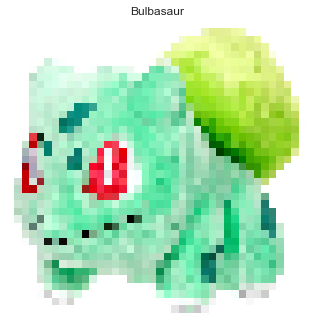

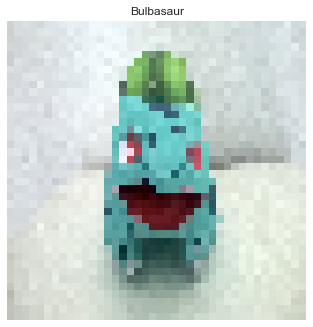

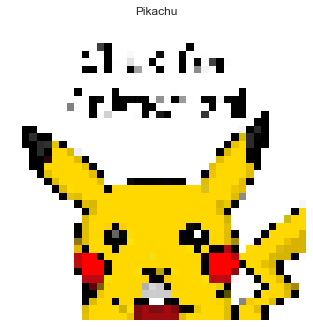

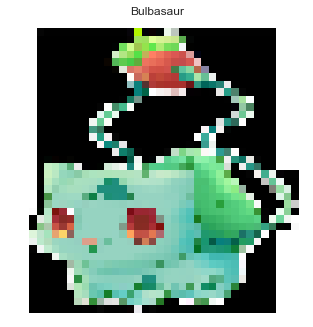

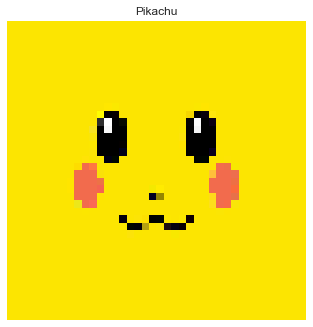

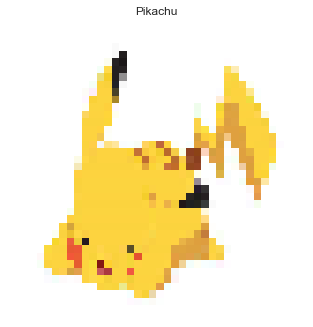

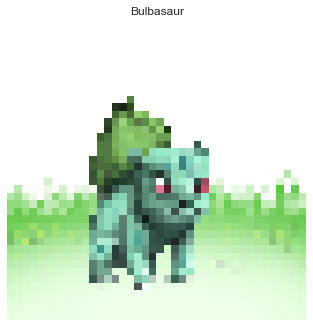

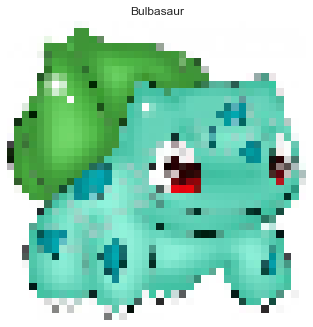

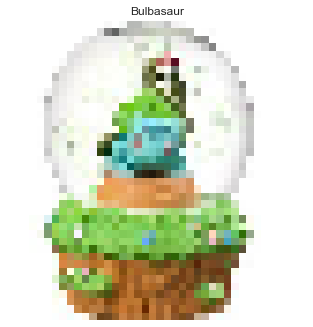

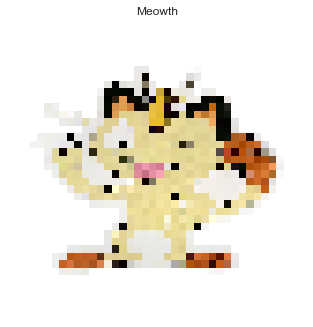

In [60]:
for i in range(10):
    randomVal = np.random.randint(0, len(X))
    drawImg(X[randomVal]/255.0, y[randomVal])

# Preprocessing and train test split

In [61]:
from sklearn.utils import shuffle

In [62]:
X, y = shuffle(X, y, random_state=0)

## Normalization

In [63]:
X = X/255.0

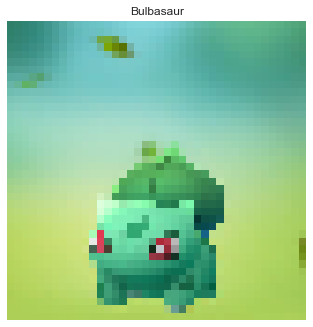

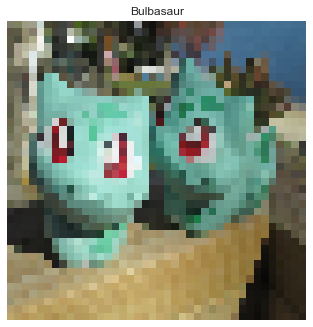

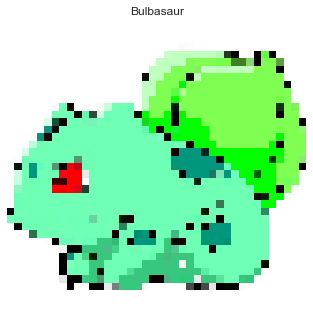

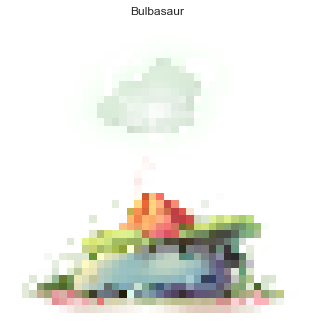

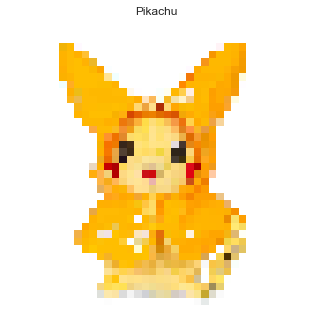

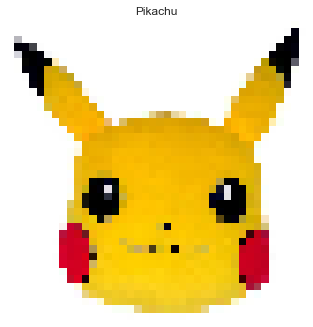

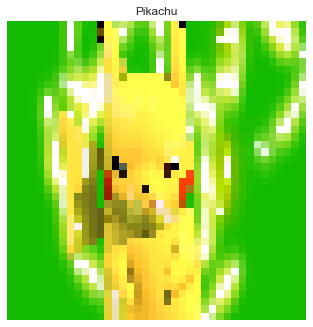

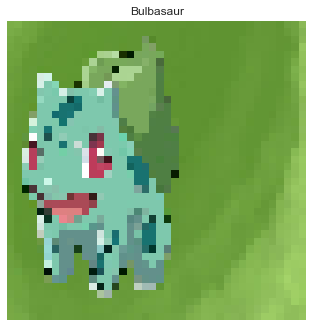

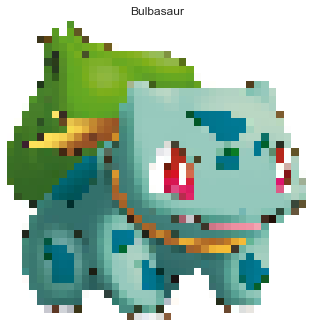

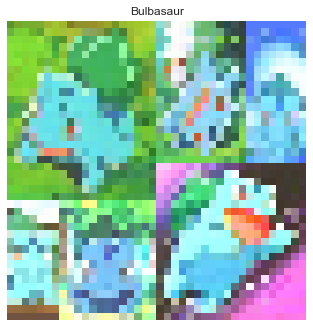

In [64]:
for i in range(10):
    drawImg(X[i].reshape(40,40,3), y[i])

In [65]:
split = int(0.8*len(X))
X = np.array(X)
y = np.array(y)
X_train = X[:split, :]
X_test = X[split:, :]
y_train = y[:split]
y_test = y[split:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((352, 40, 40, 3), (352,), (88, 40, 40, 3), (88,))

# Model

In [73]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x)
    return e_x / np.sum(e_x, axis=1, keepdims=True)

In [74]:
def loss(y_oneHotEncoding, probabilitiesForClasses):
    return -np.mean(y_oneHotEncoding * np.log(probabilitiesForClasses))

In [75]:
def oneHot(y, n_classes):
    m = y.shape[0]
    y_oht = np.zeros((m, n_classes))
    y_oht[np.arange(m), y] = 1
    return y_oht

In [76]:
# creating a 3 layer(2 hidden layers) neural networs
class neuralNetwork:
    def __init__(self, inputSize, layers, outputSize):
        self.outputSize = outputSize
        np.random.seed(0)
        model = {}

        # weights for input to first hidden layer
        model['W1'] = np.random.randn(inputSize, layers[0])
        model['b1'] = np.zeros((1, layers[0]))  # bias for first hidden layer

        # weights for first hidden layer to second hidden layer
        model['W2'] = np.random.randn(layers[0], layers[1])
        model['b2'] = np.zeros((1, layers[1]))  # bias for second hidden layer

        # weights for second hidden layer to output layer
        model['W3'] = np.random.randn(layers[1], outputSize)
        model['b3'] = np.zeros((1, outputSize))  # bias for output layer

        self.model = model
        self.activationOutputs = None

    def forward(self, X):
        z1 = np.dot(X, self.model['W1']) + self.model['b1']
        a1 = np.tanh(z1)  # using tanh as the activation function

        z2 = np.dot(a1, self.model['W2']) + self.model['b2']
        a2 = np.tanh(z2)  # using tanh as the activation function

        z3 = np.dot(a2, self.model['W3']) + self.model['b3']
        # using softmax as the activation function for the output layer
        y_ = softmax(z3)

        self.activationOutputs = (a1, a2, y_)
        return y_

    def backward(self, X, y, learningRate=0.001):

        a1, a2, y_ = self.activationOutputs

        deltaOutputLayer = y_ - y  # delta3
        dw3 = np.dot(a2.T, deltaOutputLayer)  # delta3 * a2
        db3 = np.sum(deltaOutputLayer, axis=0)  # sum of delta3

        # delta2 = (derivative of activity function(here tanh)) * delta3 * W3^T
        delta2 = (1-np.square(a2)) * \
            np.dot(deltaOutputLayer, self.model['W3'].T)
        dw2 = np.dot(a1.T, delta2)  # delta2 * a1
        db2 = np.sum(delta2, axis=0)  # sum of delta2

        # delta1 = (derivative of activity function(here tanh)) * delta2 * W2^T
        delta1 = (1-np.square(a1)) * np.dot(delta2, self.model['W2'].T)
        dw1 = np.dot(X.T, delta1)  # delta1 * X
        db1 = np.sum(delta1, axis=0)  # sum of delta1

        # updating the model parameters using gradient descent
        self.model['W1'] -= learningRate * dw1
        self.model['b1'] -= learningRate * db1

        self.model['W2'] -= learningRate * dw2
        self.model['b2'] -= learningRate * db2

        self.model['W3'] -= learningRate * dw3
        self.model['b3'] -= learningRate * db3

    def predict(self, X):
        y_ = self.forward(X)
        return np.argmax(y_, axis=1)

    def summary(self):
        W1, W2, W3 = self.model['W1'], self.model['W2'], self.model['W3']
        a1, a2, y_ = self.activationOutputs

        print("W1 ", W1.shape)
        print("A1 ", a1.shape)

        print("W2 ", W2.shape)
        print("A2 ", a2.shape)

        print("W3 ", W3.shape)
        print("Y_ ", y_.shape)

    def fit(self, X, y, epochs=100, learningRate=0.001, logs=True):
        losses = []
        classes = self.outputSize
        y_oht = oneHot(y, classes)
        for i in range(epochs):
            y_ = self.forward(X)
            l = loss(y_oht, y_)
            self.backward(X, y_oht, learningRate)
            losses.append(l)

            if logs:
                print("Epoch: ", i, " Loss: ", l)
        return losses


In [84]:
model = neuralNetwork(inputSize=4800, layers=[100, 100], outputSize=3)  

In [85]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((352, 4800), (88, 4800))

In [86]:
losses = model.fit(X_train, y_train, epochs=500, learningRate=0.0002, logs=True)

Epoch:  0  Loss:  1.6991052010172374
Epoch:  1  Loss:  1.3545147511700355
Epoch:  2  Loss:  1.2607367506468992
Epoch:  3  Loss:  1.1485767096579997
Epoch:  4  Loss:  1.0623654227701076
Epoch:  5  Loss:  0.9715036322254835
Epoch:  6  Loss:  0.9560719527464017
Epoch:  7  Loss:  0.8485919073422606
Epoch:  8  Loss:  0.7511981139884271
Epoch:  9  Loss:  0.722861858747896
Epoch:  10  Loss:  0.6709921514972268
Epoch:  11  Loss:  0.7007452077736228
Epoch:  12  Loss:  0.6214617387909191
Epoch:  13  Loss:  0.5646522616411853
Epoch:  14  Loss:  0.5158412888441444
Epoch:  15  Loss:  0.47206177181177955
Epoch:  16  Loss:  0.507112895340614
Epoch:  17  Loss:  0.4697502892198124
Epoch:  18  Loss:  0.4409180099382268
Epoch:  19  Loss:  0.4490208928502323
Epoch:  20  Loss:  0.46273615593397077
Epoch:  21  Loss:  0.39835217147531743
Epoch:  22  Loss:  0.3809183773430383
Epoch:  23  Loss:  0.3814402834177403
Epoch:  24  Loss:  0.3693537561054921
Epoch:  25  Loss:  0.34331721011453964
Epoch:  26  Loss:  0

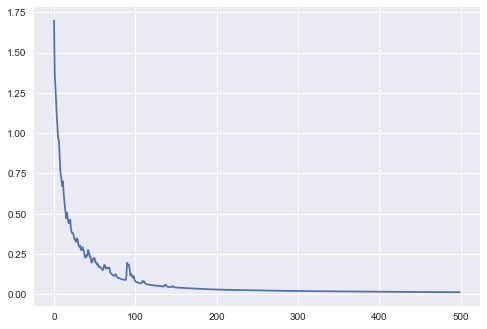

In [87]:
plt.plot(losses)
plt.show()

In [88]:
def accuracy(X, y, model):
    y_ = model.predict(X)
    return np.mean(y_ == y)

In [89]:
trainAcc = accuracy(X_train, y_train, model)
testAcc = accuracy(X_test, y_test, model)
trainAcc, testAcc

(0.9971590909090909, 0.6931818181818182)

it is evident that the model is overfitting, can use methods like:
- dropouts
- early stopping

In [90]:
from sklearn.metrics import classification_report

In [93]:
print(classification_report(model.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        42
           1       0.72      0.72      0.72        29
           2       0.47      0.47      0.47        17

    accuracy                           0.69        88
   macro avg       0.65      0.65      0.65        88
weighted avg       0.69      0.69      0.69        88



In [94]:
print(classification_report(model.predict(X_train), y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       157
           1       1.00      0.99      1.00       143
           2       0.98      1.00      0.99        52

    accuracy                           1.00       352
   macro avg       0.99      1.00      1.00       352
weighted avg       1.00      1.00      1.00       352



In [95]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [97]:
from sklearn.metrics import confusion_matrix

Confusion matrix, without normalization
[[32  3  7]
 [ 6 21  2]
 [ 4  5  8]]


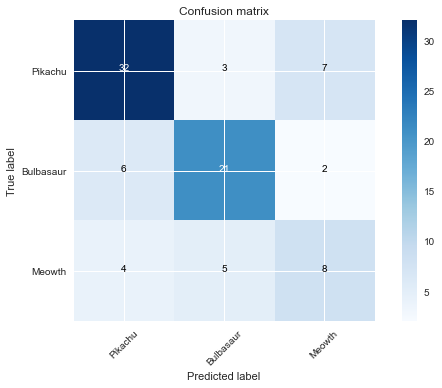

In [101]:
cnf = confusion_matrix(model.predict(X_test), y_test)
plot_confusion_matrix(
    cnf, classes=['Pikachu', 'Bulbasaur', 'Meowth'], title='Confusion matrix')


Confusion matrix, without normalization
[[157   0   0]
 [  0 142   1]
 [  0   0  52]]


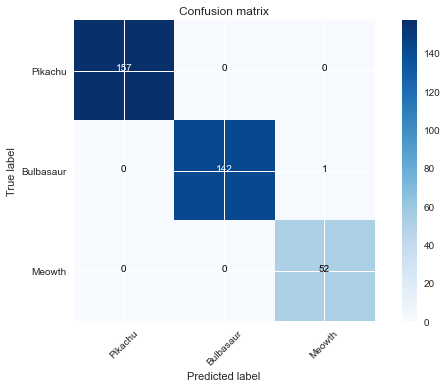

In [102]:
cnf = confusion_matrix(model.predict(X_train), y_train)
plot_confusion_matrix(
    cnf, classes=['Pikachu', 'Bulbasaur', 'Meowth'], title='Confusion matrix')
